# <u> 3.3 Hypothesis Testing </u>

In [1]:
"""
AUTHOR: F015011
DATE: April / May 2023

The following notebook contains code used to answer assessment task 3.3 "Hypothesis Testing".
"""
# import required packages
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from scipy.stats import ttest_ind, mannwhitneyu, chisquare
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from ipynb.fs.defs.task3_1 import preprocess_data


In [3]:
from ipynb.fs.defs.task3_2 import split_data, optimise_regression_model, create_proportional_subset, optimise_classifier_model, plot_grid_search_results

# Hypothesis Testing

In [4]:
def compare_models(model1, model2, X_train, y_train, X_test, y_test, model_type, alpha=0.05, test_func='ttest_ind'):
    """
    Performs a full hypothesis test to compare two data mining models using a specified statistical test.
    
    Parameters:
        model1 (object): The first model object.
        model2 (object): The second model object.
        X_train (numpy.ndarray): Training data features.
        y_train (numpy.ndarray): Training data labels.
        X_test (numpy.ndarray): Testing data features.
        y_test (numpy.ndarray): Testing data labels.
        alpha (float, optional): Significance level for the hypothesis test (default is 0.05).
        model_type (str, optional): The type of models being compared, either 'classifier' or 'regression' (default is 'classifier').
        test_func (str, optional): The name of the statistical test function to use (default is 'ttest_ind').
    
    Returns:
        result (str): The result of the hypothesis test.
    
    """
    # Train the models
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    
    # Make predictions on the test set
    model1_preds = model1.predict(X_test)
    model2_preds = model2.predict(X_test)
    
    # Calculate the difference in accuracy or mean squared error between the two models
    if model_type == 'classifier':
        accuracy_diff = np.mean(model1_preds == y_test) - np.mean(model2_preds == y_test)
    elif model_type == 'regression':
        accuracy_diff = np.mean((model1_preds - y_test)**2) - np.mean((model2_preds - y_test)**2)
    else:
        raise ValueError("Invalid model_type. Must be either 'classifier' or 'regression'.")
    
    # Select the statistical test function based on the provided string
    test_functions = {
        'ttest_ind': (ttest_ind, 'Two-Sample T-Test'),
        'mannwhitneyu': (mannwhitneyu, 'Mann-Whitney U Test'),
    }
    if test_func not in test_functions:
        raise ValueError(f"Invalid test_func. Available options are: {', '.join(test_functions.keys())}.")
    selected_test_func, test_name = test_functions[test_func]
    
    # Perform the specified statistical test
    _, p_value = selected_test_func(model1_preds, model2_preds)
    
    # Check if the difference is statistically significant
    if p_value < alpha:
        result = f"There is a significant difference between the model performances (p-value = {p_value:.4f})."
    else:
        result = f"There is no significant difference between the model performances (p-value = {p_value:.4f})."
    
    # Include the accuracy difference or mean squared error difference in the result
    if model_type == 'classifier':
        result += f" The accuracy difference is {accuracy_diff:.4f}."
    elif model_type == 'regression':
        result += f" The mean squared error difference is {accuracy_diff:.4f}."
    
    # Include the name of the statistical test in the result
    result += f" Statistical Test: {test_name}"
    
    visualise_test(model1_preds, model2_preds)
            
    return result


In [5]:
def visualise_test(model1_preds, model2_preds):
    """
    Visualises the results of the model comparisons using a box plot.
    The box plot provides a visual representation of the distribution of predictions for each model.
    
    Parameters:
        model1_preds (numpy.ndarray): Predictions from the first model.
        model2_preds (numpy.ndarray): Predictions from the second model.
    """
    # Combine the predictions from both models
    all_preds = np.concatenate((model1_preds, model2_preds))
    
    # Create labels for the models
    model1_labels = np.full(len(model1_preds), 'Model 1')
    model2_labels = np.full(len(model2_preds), 'Model 2')
    all_labels = np.concatenate((model1_labels, model2_labels))
    
    # Create a box plot to visualize the distributions
    sns.boxplot(x=all_labels, y=all_preds)
    plt.xlabel('Models')
    plt.ylabel('Predictions')
    plt.title('Distribution of predictions')
    plt.show()

# Steps for Optimisation
The following sections demonstrate the use of the defined functions and visualisations within the optimisation process (as reused from task 2); for a chosen model and dataset:
1. Read the data from a CSV file, and perform the preprocessing steps to prepare the data for analysis.
2. The data is split into training and testing with a 20/80 split.
3. A set of hyperparameters is specified for the grid search cross-validation optimisation. 
4. The best parameters, model and cross-validation results are returned. 

# Gradient Boosting Regressor Optimisation

### Best Parameters

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


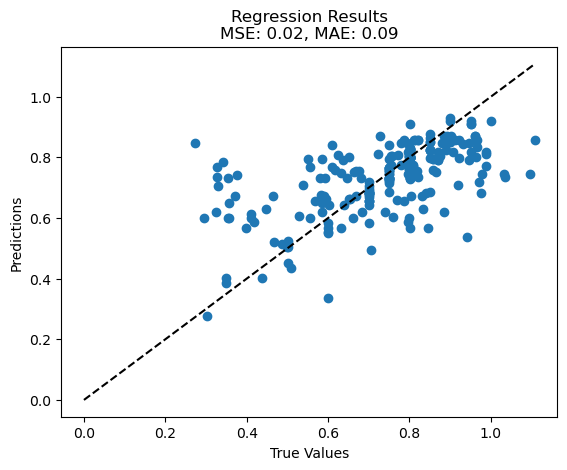

In [6]:
# Read garments_regression.csv file
garments_regression = np.genfromtxt('gwp_assessment.csv', delimiter=',', dtype=str, skip_header=True, filling_values='')

# Pre-process garments_regression data
garments_processed = preprocess_data(garments_regression, False, 'pearson')

# Split the data into training and testing sets
X_train_gwp, X_test_gwp, y_train_gwp, y_test_gwp = split_data(
    garments_processed, test_size=0.2, random_state=2002)

# Define the hyperparameters to optimize
gb_params = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

best_gb_params, gb_cv_results, gb_best_estimator = optimise_regression_model(
    GradientBoostingRegressor(), gb_params, X_train_gwp, y_train_gwp, X_test_gwp, y_test_gwp)


### Grid Search Results

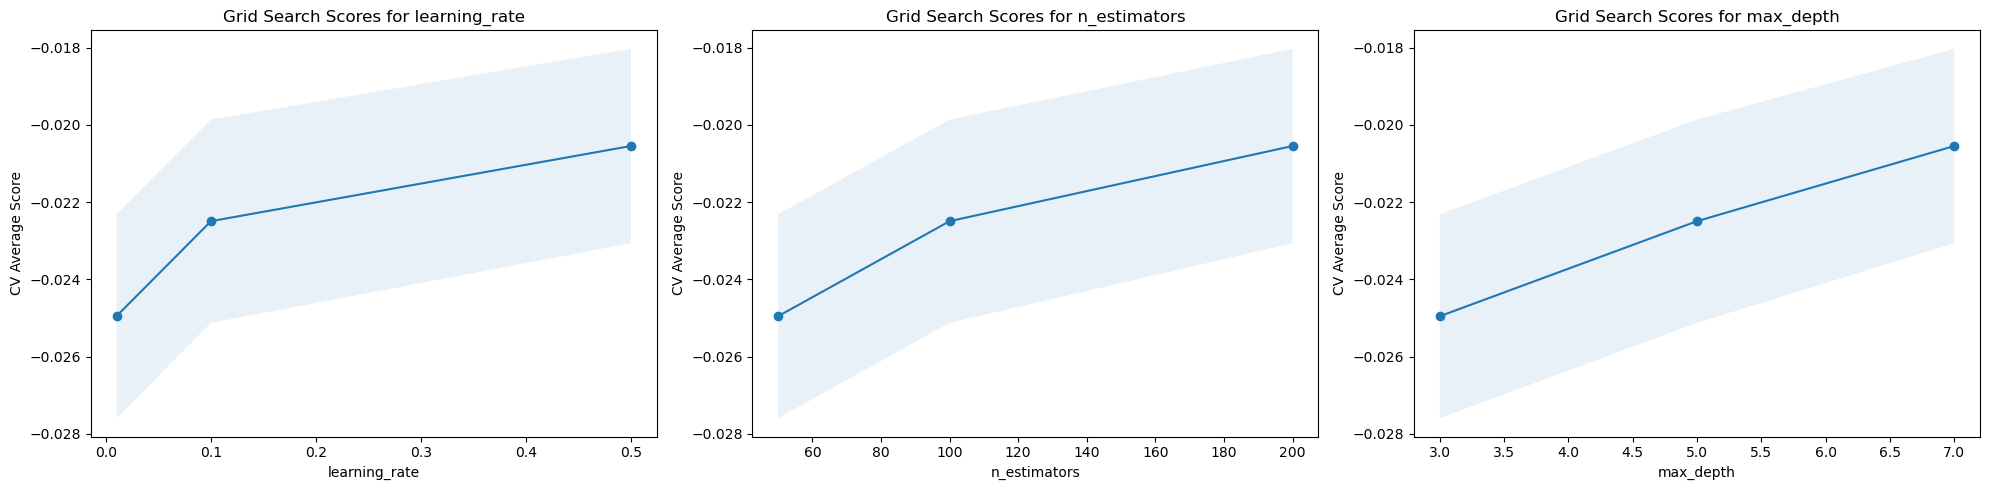

In [7]:
plot_grid_search_results(gb_cv_results, gb_params)

# K-Neighbors Classifier Optimisation

### Best Parameters

{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      1172
         1.0       0.87      0.81      0.84       394
         2.0       0.93      0.88      0.90       434

    accuracy                           0.91      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.91      0.91      0.91      2000



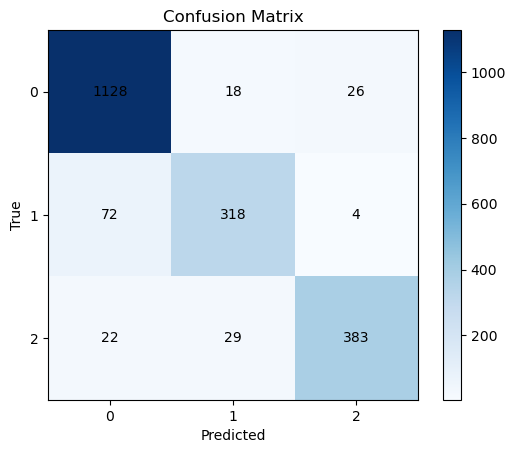

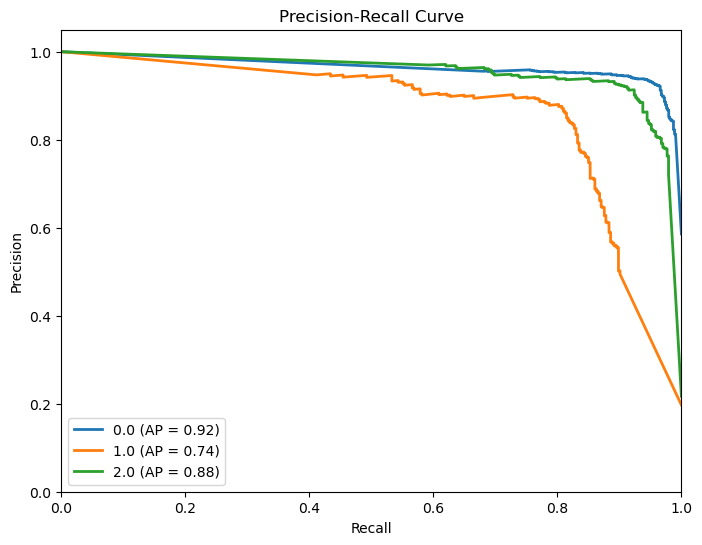

In [8]:
# Read star_classification.csv file
star_classification = np.genfromtxt(
    'star_assessment.csv', delimiter=',', dtype=str, skip_header=True)
# Pre-process star_classification data
star_processed = preprocess_data(star_classification, False, 'pearson')

star_subset = create_proportional_subset(star_processed, 0.1)

# Split the data into training and testing sets
X_train_star, X_test_star, y_train_star, y_test_star = split_data(
    star_subset, test_size=0.2, random_state=2002)

# Define the parameter grid to search over
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 50],
    'p': [1, 2]
}

# Optmise model and return results
best_knn_params, knn_cv_results, knn_best_estimator = optimise_classifier_model(
    KNeighborsClassifier(), knn_params, X_train_star, y_train_star,  X_test_star, y_test_star)


### Grid Search Results

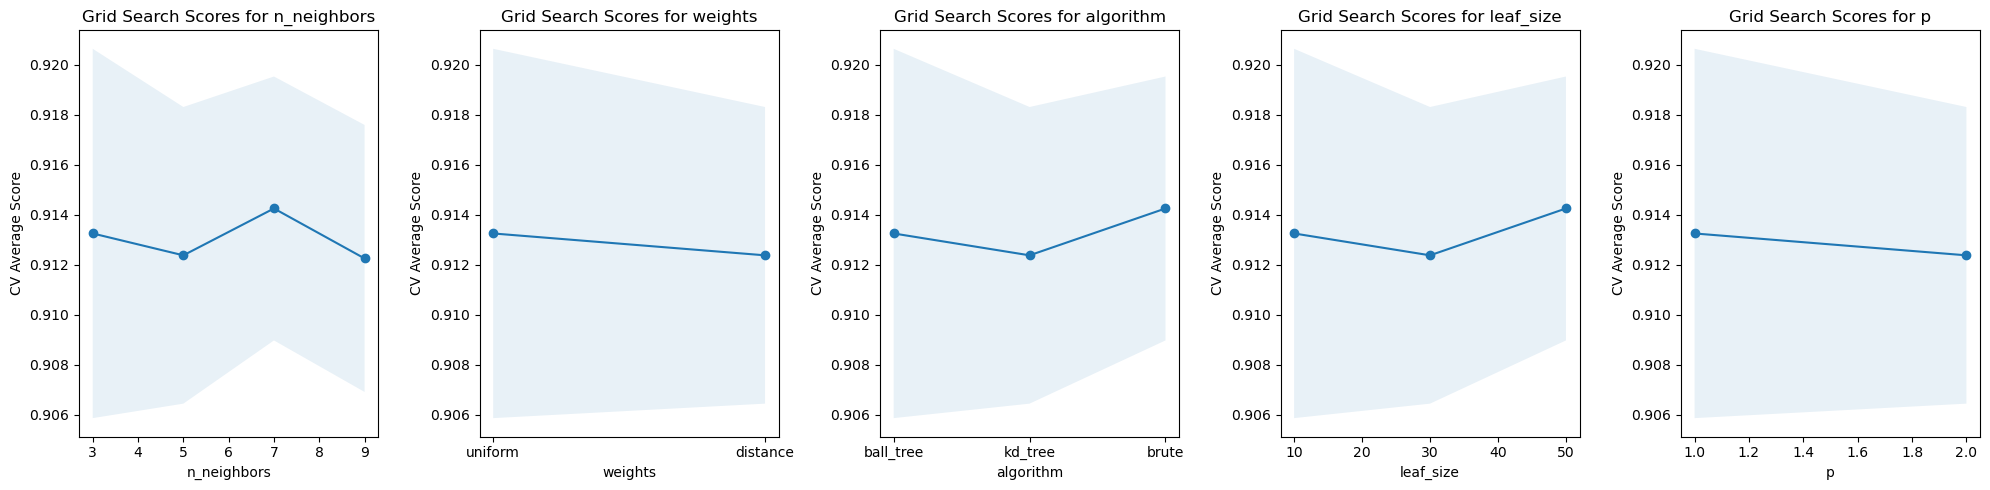

In [9]:
plot_grid_search_results(knn_cv_results, knn_params)

# Compare Models
The following section will use hypothesis testing, specifically a two-sample t-test and Mann-Whitney U Rank Test, to fasciiliitate the comparison of our optimised models from task 2 and task 3. Our regression models will be compared with their respective mean squared error (MSE) and our classification models will be compared on their respective accuracy. This will allow us to determine statistically if there is a significant difference between the model performances. We perform the optimisation process for our task 2 models again for this comparison.

The tests used operate as follows: 
- **Mann-Whitney U Rank Test:** A non-parametric test used to compare the difference between the distributions of two independent groups.
- **Paired (two sample) T-test:** A statistical test used to compare the means of two related groups. 

In [10]:
# Define the hyperparameters to optimise
rfr_params = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Optmise model and return results
best_rfr_params, rfr_cv_results, rfr_best_estimator = optimise_regression_model(RandomForestRegressor(), rfr_params, X_train_gwp, y_train_gwp, X_test_gwp, y_test_gwp, display_results=False)

In [11]:
# Define the hyperparameters to optimise
svm_params = {
    'C': [0.1, 1, 10, 50],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [1,0.1,0.01,0.001]
}

# Optmise model and return results
best_svm_params, svm_cv_results, svm_best_estimator = optimise_classifier_model(SVC(probability=True), svm_params, X_train_star, y_train_star,  X_test_star, y_test_star, display_results=False)

## Comparison of Gradient Boosting and Random Forest Classifiers

### T-test

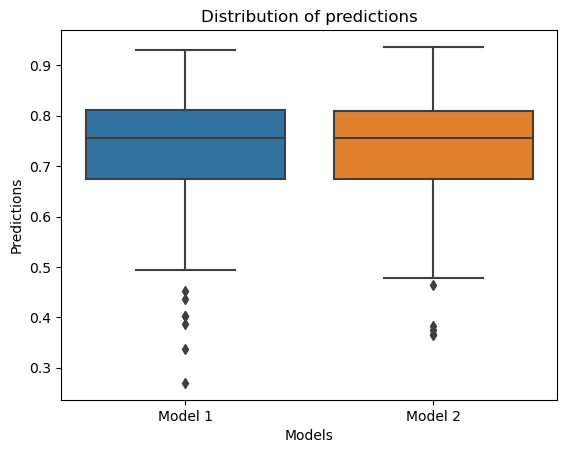

'There is no significant difference between the model performances (p-value = 0.6724). The mean squared error difference is -0.0003. Statistical Test: Two-Sample T-Test'

In [12]:
compare_models(gb_best_estimator, rfr_best_estimator, X_train_gwp, y_train_gwp, X_test_gwp, y_test_gwp, 'regression', test_func='ttest_ind')

###  Mann-Whitney U Rank Test

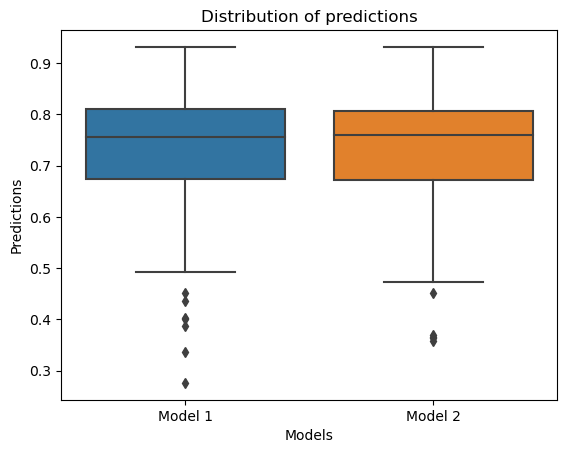

'There is no significant difference between the model performances (p-value = 0.9143). The mean squared error difference is -0.0006. Statistical Test: Mann-Whitney U Test'

In [13]:
compare_models(gb_best_estimator, rfr_best_estimator, X_train_gwp, y_train_gwp, X_test_gwp, y_test_gwp, 'regression', test_func='mannwhitneyu')

## Comparison of Support Vector and K-Nearest Neighbour Classifiers

### T-test

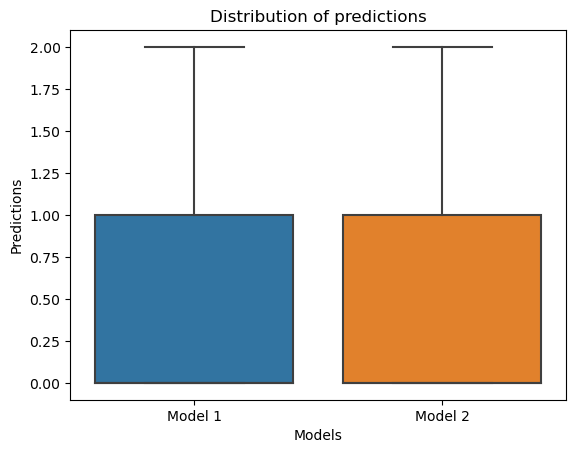

'There is no significant difference between the model performances (p-value = 0.5591). The accuracy difference is 0.0185. Statistical Test: Two-Sample T-Test'

In [14]:
compare_models(svm_best_estimator, knn_best_estimator, X_train_star, y_train_star, X_test_star, y_test_star, 'classifier', test_func='ttest_ind')

###  Mann-Whitney U Rank Test

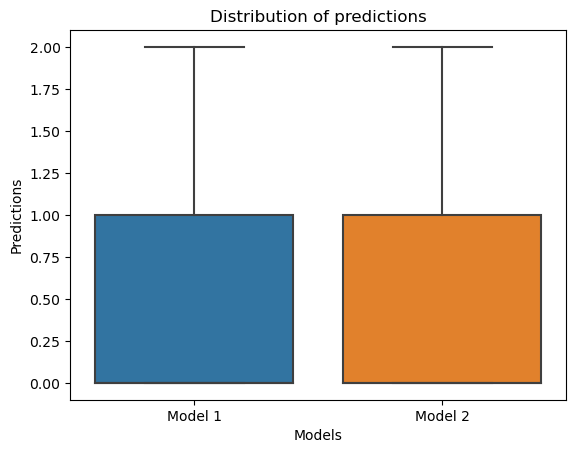

'There is no significant difference between the model performances (p-value = 0.5605). The accuracy difference is 0.0185. Statistical Test: Mann-Whitney U Test'

In [15]:
compare_models(svm_best_estimator, knn_best_estimator, X_train_star, y_train_star, X_test_star, y_test_star, 'classifier', test_func='mannwhitneyu')

# Markdown Question 3

**What was the hypothesis you rejected for both datasets in this task? How does p-value affect your decision?**

In this case, the hypothesis being tested aimed to determine a significant difference in performance between the two given machine learning models. The null hypothesis assumes the mean accuracy for the classification tasks is equal between the two models being compared. Similarly, for our regression models the null hypothesis assumes the mean squared error for the two models is equal. Hence, the alternate hypothesis within this test suggests there is a significant difference in performance between the models, i.e., one model has a significantly lower performance score than the other. The p-value represents an estimated probability that we should reject the null hypothesis, assuming it is true. If this p-value is less than the set significance level (alpha, commonly set at 0.05), we can say with statistical certainty there is sufficient evidence the performance differs between models (we reject the null hypothesis). If the p-value is greater than or equal to the significance level, there is insufficient evidence to suggest otherwise.